## Summary of Analysis of Periodic Processes ($\S$ 10.3)

If a system is always variable, and the variability is **periodic**, then we want to characterize the process by determining its period and amplitude.

If the data well-sample the process (high "cadence" relative to the period), then determining the parameters of the process is easy.  If the data are not well sampled, the jobs is harder (but still possible!).

### A Single Sinusoid

Let's take the case where the data are drawn from a single sinusoidal signal:

$$y(t)=a \sin(\omega t)+b \cos(\omega t),$$

where $A=(a^2+b^2)^{1/2}$ and $\phi=\tan^{−1}(b/a)$

and determine whether or not the data are indeed consistent with periodic variability and, if so, what is the period.

Assuming constant uncertainties on the data, the likelihood for this model becomes,

$$L\equiv p({t,y}|\omega,a,b,\sigma)=\prod^N_{j=1}\frac{1}{\sqrt{2π}\sigma} \exp \left(\frac{−[y_j−a \sin(\omega t_j)−b \cos(\omega t_j)]}{2\sigma^2} \right), $$

where $y_i$ is the measurement (e.g., the brightness of a star) taken at time $t_i$.

The posterior can be simplified to

$$p(\omega|\{t,y\}, \sigma) \propto \sigma^{−N} \exp \left(\frac{−NQ}{2\sigma^2} \right) \propto \exp \left(\frac{P(\omega)}{\sigma^2} \right).$$


where $P(\omega)$ is the [periodogram](https://en.wikipedia.org/wiki/Periodogram), which is just a plot of the "power" at each possible period (as illustrated below):

<img src="../figures/periodogram.png">

The "best value" $\omega$ is given by

$$\chi^2(\omega) =  \chi_0^2 \, \left[1 - {2 \over N \, V}  \, P(\omega) \right],$$

where $P(\omega)$ is the periodogram and $\chi_0^2$ is the $\chi^2$ for a model with $y(t)$=constant:

$$  \chi_0^2 = {1 \over \sigma^2} \sum_{j=1}^N y_j^2 = {N \, V \over \sigma^2}$$

We renormalise the periodogram, defining the [Lomb-Scargle periodogram](https://en.wikipedia.org/wiki/Least-squares_spectral_analysis#The_Lomb.E2.80.93Scargle_periodogram) as

$$P_{\rm LS}(\omega) = \frac{2}{N V} P(\omega),$$  where $0 \le P_{\rm LS}(\omega) \le 1$.

With this renormalization, the ratio of $\chi^2(\omega)$ (for the periodic model) 
relative to $\chi^2_0$ (for the pure noise model) is
$${\chi^2(\omega) \over \chi^2_0}=  1 - P_{LS}(\omega).$$

So, to determine if our source is variable or not, we first compute $P_{\rm LS}(\omega)$ and then model the odds ratio for our variability model vs. a no-variability model.

If our variability model is "correct", then the peak of $P(\omega)$ [found by grid search] gives the best $\omega$.

Below is an example of a LS periodogram generated using 100 points drawn from $y(t|P) = 10 + \sin(2\pi t/P),$ with $P=0.3$.  

[http://www.astroml.org/gatspy/periodic/lomb_scargle.html](http://www.astroml.org/gatspy/periodic/lomb_scargle.html) gives more information on astroML's implementation.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

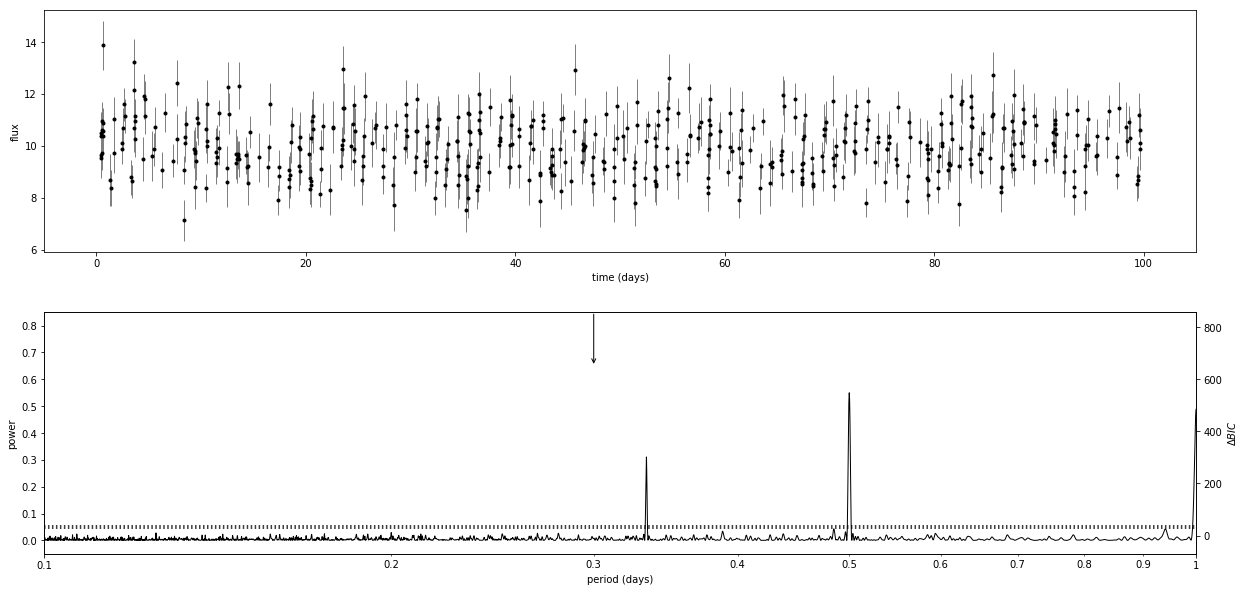

In [5]:
# Similar to Figure 10.15
# Author: Jake VanderPlas
# License: BSD
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

#------------------------------------------------------------
# Generate Data
np.random.seed(0)
N = 500  #Trying changing this value
P = 0.5  #Trying changing this value, 
         #don't forget to adjust the "period" grid below

t = np.random.randint(100, size=N) + 0.3 + 0.4 * np.random.random(N)
y = 10 + np.sin(2 * np.pi * t / P)
dy = 0.5 + 0.5 * np.random.random(N)
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# Compute periodogram
period = 10 ** np.linspace(-1, 0, 10000)  #Adjust this as needed.
omega = 2 * np.pi / period
PS = lomb_scargle(t, y_obs, dy, omega, generalized=True)

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
                           N_bootstraps=500, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.25)

# First panel: the data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.set_xlim(-5, 105)

# Second panel: the periodogram & significance levels
ax1 = fig.add_subplot(212, xscale='log')
ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black')
ax1.plot([period[0], period[-1]], [sig5, sig5], ':', c='black')

ax1.annotate("", (0.3, 0.65), (0.3, 0.85), ha='center',
             arrowprops=dict(arrowstyle='->'))

ax1.set_xlim(period[0], period[-1])
ax1.set_ylim(-0.05, 0.85)

ax1.set_xlabel(r'period (days)')
ax1.set_ylabel('power')

# Twin axis: label BIC on the right side
ax2 = ax1.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_locator(plt.LogLocator(10))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

plt.show()

If that isn't impressive, try changing the period to 5-10 days and the number of points to 200-300 (you'll need to increase `period` array as appropriate, note that it is a log quantity) to compare this to a situation that is more obvious.  Now are you impressed?

### False Alarm Probability

To determine the  chance that these peaks are due to random fluctuations and that 
underlying time series is simply noise, we compute the **false alarm probability** from the following equation.

$$ {p(Var\,|\,Peak) \over p(Const\,|\,Peak)} = {1 \over FAP} \, {p(Var) \over p(Const)}. $$

In order to have a reliable detection of the period we want the LHS $>$10, then depending on the ratio of priors [p(Var)/p(Const)], we determine the required FAP.

The two horizontal dashed lines in the periodogram above correspond to FAPs of
0.01 and 0.001. 

### Aliasing

But why did we have 3 peaks above the line FAP=0.001??? 

The two most common problems are sampling aliases (e.g. observations spaced 
by roughly 1 day) and inability of a single sinusoid to fit the shape of light
curve (always check if there is another significant peak at twice the best-fit 
period). 

### Generalized Lomb-Scargle

The Lomb-Scargle periodogram is a fit to a model:

$$y(t)=a \sin(\omega t)+b \cos(\omega t),$$

whose mean is zero. In reality, the observed variability is typically around some (mean) value, not zero. We deal with this by subtracting the mean of the sample $\overline{y}$ from the data before performing the periodogram analysis.

That only works if $\overline{y}$ is a good estimator of the mean of the distribution, $y(t)$ -- if the data is equally sampled at all phases. However, in practice, the data may not equally sample all of the phases.

For example, consider the case of a star that has a period of one day and the fact that a single optical telescope only takes data at night. In that case you we might get something like the top panel below:

![Ivezic, Figure 10.16](http://www.astroml.org/_images/fig_LS_sg_comparison_3.png)


The "generalized" Lomb-Scargle approach (also implemented in astroML) can help with this as can be seen in the bottom panel above. It fits the model with non-zero mean:

$$y(t)=a \sin(\omega t)+b \cos(\omega t) + C$$

See also [Figure 10.16](http://www.astroml.org/book_figures/chapter10/fig_LS_sg_comparison.html) in the textbook (and note the erratum!).

### Multiband LS periodograms

One of the issues that we are going to be dealing with in astronomy over the next decade as the LSST project comes online is the problem of sparsely-sampled light curves, but with multiple light curves for each object -- one for each "bandpass" as seen below:

<img src="../figures/multibandLS.png" style="float: right; width: 100%; margin-right: 1%;">

The generalized LS was an extension to account for the mean value. We can build on this to account for multiple bands by fitting for a global period and a per-band period

$\begin{eqnarray}
  &y_k(t|\omega,\theta) =
  \theta_0 + \sum_{n=1}^{N_{base}} \left[\theta_{2n - 1}\sin(n\omega t) + \theta_{2n}\cos(n\omega t)\right] +&\nonumber
  &\theta^{(k)}_0 + \sum_{n=1}^{N_{band}} \left[\theta^{(k)}_{2n - 1}\sin(n\omega t) + \theta^{(k)}_{2n}\cos(n\omega t)\right].&
\end{eqnarray}$

(Actually this illustrates a global offset and per-band offsets and not periods.)

The total number of parameters for $K$ filters is then $M_K = (2N_{base} + 1) + K(2N_{band} + 1)$. 

To keep the parameters constrained we apply regularization (see regression).

The important feature of this model is that _all bands_ share the same base parameters, $\theta$, while their offsets $\theta^{(k)}$ are determined individually.

Below we show the multi-band light curves of an RR Lyrae star as an example.  

A fit with just one base term isn't so great:

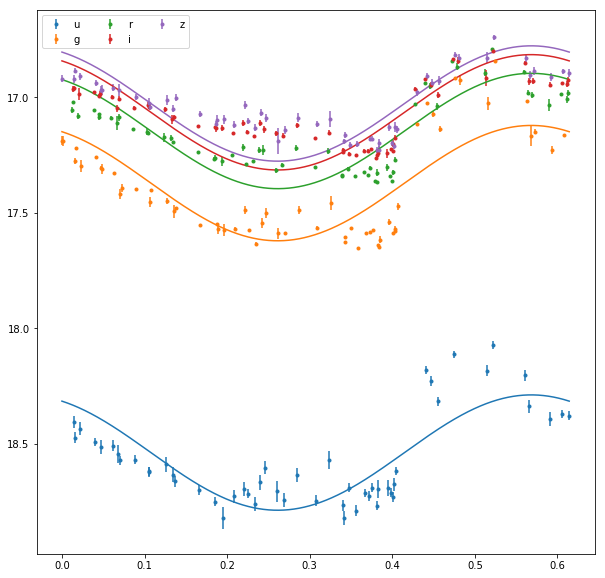

In [6]:
from gatspy.datasets import fetch_rrlyrae
rrlyrae = fetch_rrlyrae()
lcid = rrlyrae.ids[0]

t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
period = rrlyrae.get_metadata(lcid)['P']

from gatspy.periodic import LombScargleMultiband
model = LombScargleMultiband(Nterms_base=1, Nterms_band=0)
model.fit(t, y, dy, filts)
periods = np.linspace(period - 0.1, period + 0.1, 2000)
power = model.periodogram(periods)

def plot_model(model, lcid):
    t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
    model.fit(t, y, dy, filts)
    
    tfit = np.linspace(0, period, 1000)
    for filt in 'ugriz':
        mask = (filts == filt)
        eb = plt.errorbar(t[mask] % period, y[mask], dy[mask], fmt='.', label=filt)
        yfit = model.predict(tfit, filt, period=period)
        plt.plot(tfit, yfit, color=eb[0].get_color())
    plt.gca().invert_yaxis()
    plt.legend(ncol=3, loc='upper left')
    
fig = plt.figure(figsize=(10,10))
plot_model(LombScargleMultiband(Nterms_base=1, Nterms_band=0), lcid)

But with 4 base terms, we get excellent results.  Note that this works well for this case where we don't expect $\omega$ to be bandpass dependent, but it might not work so well for quasars.

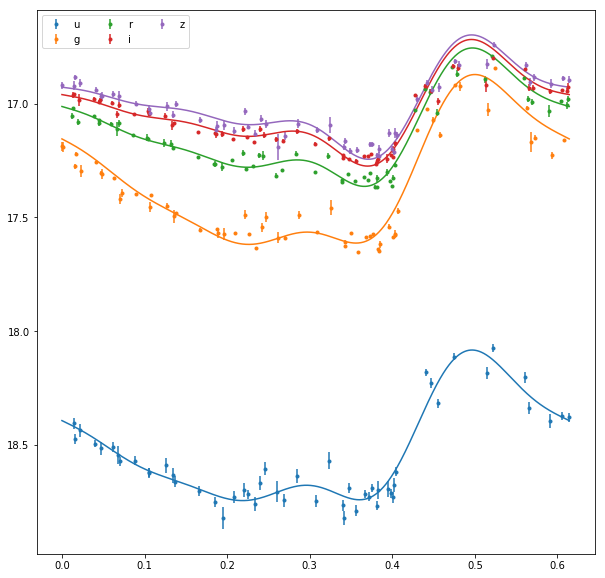

In [7]:
fig = plt.figure(figsize=(10,10))
plot_model(LombScargleMultiband(Nterms_base=4, Nterms_band=1), lcid)

## Analysis of Stochastic Processes ($\S$ 10.5)

If a system is always variable, but the variability is not (infinitely) predictable, then we have a [**stochastic**](https://en.wikipedia.org/wiki/Stochastic) process.  Counter to what you may think, these processes can also be characterized.

Take a (stochastically varying) quasar which has both *line* and *continuum* emission and where the line emission is stimulated by the continuum.  Since there is a physical separation between the regions that produce each type of emission, we get a delay between the light curves as can be seen here:

![Peterson 2001, RM](https://ned.ipac.caltech.edu/level5/Sept01/Peterson2/Figures/figure24.jpg)

To understand stochastic processes, let's first talk about [correlation functions](https://en.wikipedia.org/wiki/Correlation_function).  A correlation function ($\S$ 6.5) gives us information about the time delay between 2 processes.  If one time series is derived from another simply by shifting the time axis by $t_{\rm lag}$, then their correlation function will have a peak at $\Delta t = t_{\rm lag}$.

The correlation function between $f(t)$, and $g(t)$ is defined as
$${\rm CF}(\Delta t) = \frac{\lim_{T\rightarrow \infty}\frac{1}{T}\int_T f(t)g(t+\Delta t)dt }{\sigma_f \sigma_g}$$

Computing the correlation function is basically the mathematical processes of sliding the two curves over each other and computing the degree of similarity for each step in time.  The peak of the correlation function reveals the time delay between the processes.  Below we have the correlation function of the line and continuum emission from a quasar, which reveals a $\sim$ 15 day delay between the two.

![Peterson 2001, RM](https://ned.ipac.caltech.edu/level5/Sept01/Peterson2/Figures/figure25.jpg)

In an **autocorrelation function (ACF)**, $f(t)= g(t)$ and we instead are revealing information about variability timescales present in a process.
If the values of $y$ are uncorrelated, then ACF$(\Delta t)=0$.

### What can the ACF tell us?

If the values of $y$ are uncorrelated, then ACF$(\Delta t)=0$ (except for ACF$(0)=1$).

For processes that "retain memory" of previous states only for some characteristic time $\tau$, the ACF will vanish for $\Delta t \gg \tau$.

Turning that around, the predictability of future behavior of future behavior of such a process is limited to times up to $\sim \tau$; you have to "let the process run" to know how it will behave at times longer than that.

### Power Spectral Density

The Fourier Transform of an ACF is the [Power Spectral Density (PSD)](https://en.wikipedia.org/wiki/Spectral_density).  So, the PSD is an analysis in frequency space and the ACF is in time space (the Wiener-Khinchin theorem describes the 
fact that the ACF and PSD are a Fourier pair). 

For example, for a sinusoidal function in time space, the ACF will have the same period, $T$. Conversly, the PSD in frequency space will be a $\delta$ function centered on $\omega = 1/2\pi T$.

### The Structure Function

The *structure function* is another quantity that is frequently used in astronomy and is related to the ACF:

$${\rm SF}(\Delta t) = {\rm SF}_\infty[1 - {\rm ACF}(\Delta t)]^{1/2},$$

where ${\rm SF}_\infty$ is the standard deviation of the time series as evaluated on timescales much larger than any charateristic timescale.

The structure function is interesting because it's equal to the standard deviation of the distribution of the differences of $y(t_2) - y(t_1)$ evaluated at many different $t_1$ and $t_2$ (i.e., with a time lag of $\Delta t = t_2 - t_1$), and divided by $\sqrt 2$.

This is of practical use: if I have a series of observations $y_i$ (taken at random times $t_i$) it's relatively straighforward to compute the structure function.

### Damped Random Walk

A DRW is described by a stochastic differential equation which includes a damping term that pushes $y(t)$ back towards the mean, hence the name **damped random walk**.   

The ACF for a DRW is given by
$$ ACF(t) = \exp(-t/\tau),$$
where $\tau$ is the characteristic timescale (i.e., the damping timescale).

The DRW structure function can be written as
$$ SF(t) = SF_{\infty}[1-\exp(-t/\tau)]^{1/2}.$$

###  Structure Function for Dampled Random Walk

<img src="../figures/MacLeod2010.png" alt="Drawing" style="width: 500px;"/>

The PSD is then
$$ PSD(f) = \frac{\tau^2 SF_{\infty}^2}{1+(2\pi f \tau)^2},$$
which means that a DRW is a $1/f^2$ process at high frequency.  The *damped* part comes from the flat PSD at low frequency.

More generically, if ${\rm SF} \propto t^{\alpha}$, then ${\rm PSD} \propto \frac{1}{f^{1+2\alpha}}$.

So an analysis of a stochastic system can be done with either the ACF, SF, or PSD.

The SF example above was an example of a DRW: the light curve is strongly correlated a short timescales, but uncorrelated at long timescales. This is observed in optical variability of quasar continuum light; in fact, it works so well that one can use this model to distinguish quasars from stars, based solely on the variability they exhibit.

AstroML has [time series](http://www.astroml.org/modules/classes.html#module-astroML.time_series) and [Fourier](http://www.astroml.org/modules/classes.html#module-astroML.fourier) tools for generating light curves drawn from a power law in frequency space.  Note that these tools define $\beta = 1+2\alpha$  ($\beta=2$ for a random walk). 

### Different stochastic processes

* A stochastic process with $1/f^2$ spectrum is known as random walk (if discrete) or Brownian motion (or, more accurately, Wiener process) if continuous. These physically occur when the value being observed is subjected to a series of independent changes of similar size. It's also sometimes called as "red noise". Quasar variability exhibits $1/f^2$ properties at high frequencies (that is, short time scales, below a year or so). 
* A stochastic process with $1/f$ spectrum are sometimes called "long-term memory processes" (also sometimes know as "pink noise"). They have equal energy at all octaves (or over any other logarithmic frequency interval). This type of process has infinite variance and an undefined mean (similar to a Lorentzian distribution). 
* A process with a constant PSD is frequently referred to as "white noise" -- it has equal intensity at all frequencies. This is a process with no memory -- each measurement is independent of all others. 

Let's play with the code below to make a plot of counts vs. time and of the PSD vs. frequency for both a $1/f$ and a $1/f^2$ process. 

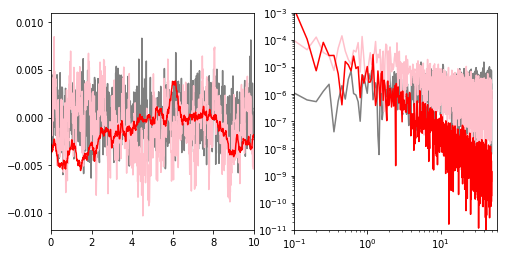

In [13]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import generate_power_law
from astroML.fourier import PSD_continuous

N = 2014
dt = 0.01
betaRed = 2  # Complete
betaPink = 1  # Complete
betaWhite = 0  # Complete

t = dt * np.arange(N)
yRed = generate_power_law(N, dt, betaRed)
yPink = generate_power_law(N, dt, betaPink) # Complete
yWhite = generate_power_law(N, dt, betaWhite)/10.0 # Complete
fRed, PSDred = PSD_continuous(t, yRed)   # Complete
fPink, PSDpink = PSD_continuous(t, yPink)       # Complete
fWhite, PSDwhite = PSD_continuous(t, yWhite)    # Complete
    
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.plot(t, yWhite, c='Grey')
ax1.plot(t, yPink, c='Pink')
ax1.plot(t, yRed, '-r')
ax1.set_xlim(0, 10)

ax2 = fig.add_subplot(122, xscale='log', yscale='log')
ax2.plot(fWhite, PSDwhite, c='Grey')   
ax2.plot(fPink, PSDpink, c='Pink')  
ax2.plot(fRed, PSDred, '-r')  
ax2.set_xlim(1E-1, 60)
ax2.set_ylim(1E-11, 1E-3)

plt.show()

You should find that, because the power at high frequency is larger for $1/f$, that light curve will look noisier.

We can even *hear* the difference:
[https://www.youtube.com/watch?v=3vEDZ-_iLNU)](https://www.youtube.com/watch?v=3vEDZ-_iLNU)

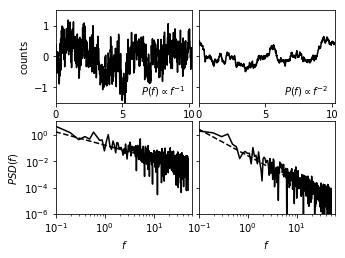

In [14]:
# Ivezic, Figure 10.29
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import generate_power_law
from astroML.fourier import PSD_continuous

N = 1024
dt = 0.01
factor = 100

t = dt * np.arange(N)
random_state = np.random.RandomState(1)

fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(wspace=0.05)

for i, beta in enumerate([1.0, 2.0]):
    # Generate the light curve and compute the PSD
    x = factor * generate_power_law(N, dt, beta, random_state=random_state)
    f, PSD = PSD_continuous(t, x)

    # First axes: plot the time series
    ax1 = fig.add_subplot(221 + i)
    ax1.plot(t, x, '-k')

    ax1.text(0.95, 0.05, r"$P(f) \propto f^{-%i}$" % beta,
             ha='right', va='bottom', transform=ax1.transAxes)

    ax1.set_xlim(0, 10.24)
    ax1.set_ylim(-1.5, 1.5)

    ax1.set_xlabel(r'$t$')

    # Second axes: plot the PSD
    ax2 = fig.add_subplot(223 + i, xscale='log', yscale='log')
    ax2.plot(f, PSD, '-k')
    ax2.plot(f[1:], (factor * dt) ** 2 * (2 * np.pi * f[1:]) ** -beta, '--k')

    ax2.set_xlim(1E-1, 60)
    ax2.set_ylim(1E-6, 1E1)

    ax2.set_xlabel(r'$f$')

    if i == 1:
        ax1.yaxis.set_major_formatter(plt.NullFormatter())
        ax2.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax1.set_ylabel(r'${\rm counts}$')
        ax2.set_ylabel(r'$PSD(f)$')

plt.show()

### ACF for Unevenly Sampled Data

astroML also has tools for computing the ACF of unevenly sampled data using two different (Scargle) and (Edelson & Krolik) methods: [http://www.astroml.org/modules/classes.html#module-astroML.time_series](http://www.astroml.org/modules/classes.html#module-astroML.time_series)

One of the tools is for generating a **damped random walk (DRW)**.  Above we found that a random walk had a $1/f^2$ PSD.  A *damped* random walk is a process "remembers" its history only for a characteristic time, $\tau$. The ACF vanishes for $\Delta t \gg \tau$.

In [15]:
# Syntax for EK and Scargle ACF computation
import numpy as np
from astroML.time_series import generate_damped_RW
from astroML.time_series import ACF_scargle, ACF_EK

t = np.arange(0,1000)
y = generate_damped_RW(t, tau=300)
dy = 0.1
y = np.random.normal(y,dy)

ACF_scargle, bins_scargle = ACF_scargle(t,y,dy)
ACF_EK, ACF_err_EK, bins_EK = ACF_EK(t,y,dy)

Figure 10.30 below gives an example of an ACF for a DRW, which mimics the variability that we might see from a quasar.

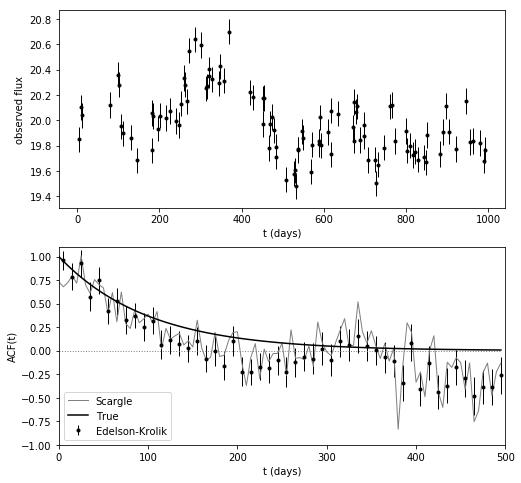

In [16]:
# Ivezic, Figure 10.30
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.time_series import lomb_scargle, generate_damped_RW
from astroML.time_series import ACF_scargle, ACF_EK

#------------------------------------------------------------
# Generate time-series data:
#  we'll do 1000 days worth of magnitudes

t = np.arange(0, 1E3)
z = 2.0
tau = 300
tau_obs = tau / (1. + z)

np.random.seed(6)
y = generate_damped_RW(t, tau=tau, z=z, xmean=20)

# randomly sample 100 of these
ind = np.arange(len(t))
np.random.shuffle(ind)
ind = ind[:100]
ind.sort()
t = t[ind]
y = y[ind]

# add errors
dy = 0.1
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# compute ACF via scargle method
C_S, t_S = ACF_scargle(t, y_obs, dy, n_omega=2 ** 12, omega_max=np.pi / 5.0)

ind = (t_S >= 0) & (t_S <= 500)
t_S = t_S[ind]
C_S = C_S[ind]

#------------------------------------------------------------
# compute ACF via E-K method
C_EK, C_EK_err, bins = ACF_EK(t, y_obs, dy, bins=np.linspace(0, 500, 51))
t_EK = 0.5 * (bins[1:] + bins[:-1])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 8))

# plot the input data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
ax.plot(t_S, C_S, '-', c='gray', lw=1, label='Scargle')
ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1, label='Edelson-Krolik')
ax.plot(t_S, np.exp(-abs(t_S) / tau_obs), '-k', label='True')
ax.legend(loc=3)

ax.plot(t_S, 0 * t_S, ':', lw=1, c='gray')

ax.set_xlim(0, 500)
ax.set_ylim(-1.0, 1.1)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')

plt.show()

## Autoregressive Models

For processes like these that are not periodic, but that "retain memory" of previous states, we can use [autoregressive models](https://en.wikipedia.org/wiki/Autoregressive_model).

A random walk is an example of such a process; every new value is given by the preceeding value plus some noise:

$$y_i = y_{i-1} + \epsilon_i.$$

If the coefficient of $y_{i-1}$ is $>1$ then it is known as a geometric random walk, which is typical of the stock market.  (So, when you interview for a quant position on Wall Street, you tell them that you are an expert in using autoregressive geometric random walks to model stochastic processes.)

In the random walk case above, each new value depends only on the immediately preceeding value.  But we can generalized this to include $p$ values:

$$y_i = \sum_{j=1}^pa_jy_{i-j} + \epsilon_i$$

We refer to this as an [**autoregressive (AR)**](https://en.wikipedia.org/wiki/Autoregressive_model) process of order $p$: $AR(p)$.  For a random walk, we have $p=1$, and $a_1=1$.

If the data are drawn from a "stationary" process (one where it doesn't matter what region of the light curve you sample [so long as it is representative]), the $a_j$ satisfy certain conditions.

One thing that we might do then is ask whether a system is more consistent with $a_1=0$ or $a_1=1$ (noise vs. a random walk).

Below are some example light curves for specific $AR(p)$ processes.  In the first example, $AR(0)$, the light curve is simply responding to noise fluctuations.  In the second example, $AR(1)$, the noise fluctuation responses are persisting for slightly longer as the next time step depends positively on the time before.  For the 3rd example, nearly the full effect of the noise spike from the previous time step is applied again, giving particularly long and high chains of peaks and valleys.  In the 4th example, $AR(2)$, we have long, but low chains of peaks and valleys as a spike persists for an extra time step.  Finally, in the 5th example, the response of a spike in the second time step has the opposite sign as for the first time step, and both have large coefficients, so the peaks and valleys are both quite high and quite narrowly separated.

![AR Examples](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/ArTimeSeries.svg/1000px-ArTimeSeries.svg.png)

A [**moving average (MA)**](https://en.wikipedia.org/wiki/Moving-average_model) process is similar to an AR process, but instead the value at each time step depends not on the *value* of previous time step, but rather the *perturbations* from previous time steps.  It is defined as

$$y_i = \epsilon_i + \sum_{j=1}^qb_j\epsilon_{i-j}.$$

So, for example, an MA(q=1) process would look like
$$y_i = \epsilon_{i} + b_1\epsilon_{i-1},$$

whereas an AR(p=2) process would look like

$$y_i = a_1y_{i-1} +  a_2y_{i-2} + \epsilon_i$$

So, in an $MA$ process a shock affects only the current value and $q$ values into the future.  In an $AR$ process a shock affects *all* future values.

Below is some code and a plot that illustrates this.

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


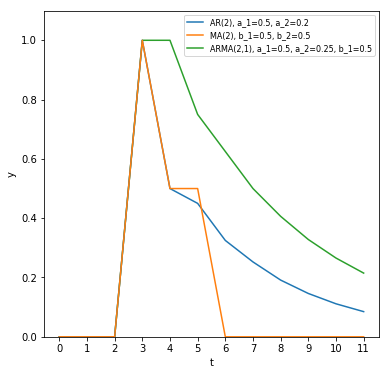

In [17]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

N=10

#epsilon = np.array([0,0,0,1,0,0,0,0,0,0,0,0])
epsilon = np.zeros(N+2)
epsilon[3] = 1
yAR=np.zeros(N+2)
yMA=np.zeros(N+2)
yARMA=np.zeros(N+2)

for i in np.arange(N)+2:
    # Complete
    yAR[i] = 0.5*yAR[i-1] + 0.2*yAR[i-2] + epsilon[i]
    yMA[i] = epsilon[i] + 0.5*epsilon[i-1] + 0.5*epsilon[i-2]
    yARMA[i] = 0.25*yARMA[i-2] + 0.5*yARMA[i-1] + epsilon[i] + 0.5*epsilon[i-1] 
    #print i, yAR[i], yMA[i]

fig = plt.figure(figsize=(6, 6))
t = np.arange(len(yAR))
plt.plot(t,yAR,label="AR(2), a_1=0.5, a_2=0.2")
plt.plot(t,yMA,label="MA(2), b_1=0.5, b_2=0.5")
plt.plot(t,yARMA,label="ARMA(2,1), a_1=0.5, a_2=0.25, b_1=0.5",zorder=0)
plt.xlabel("t")
plt.ylabel("y")
plt.legend(loc="upper right",prop={'size':8})
plt.ylim([0,1.1])
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))

plt.show()

Note that I also included an ARMA(2,1) model, which combines AR(2) and MA(1):
$$y_i = a_1y_{i-1} +  a_2y_{i-2} + \epsilon_i + b_1 \epsilon_{i-1}.$$

I found these videos particularly helpful in trying to understand these processes.

[MA(1)](https://www.youtube.com/watch?v=lUhtcP2SUsg)

[AR(1)](https://www.youtube.com/watch?v=AN0a58F6cxA)

[ARMA(1,1)](https://www.youtube.com/watch?v=Pg0RnP1uLVc)

### CARMA Models

$AR$ and $ARMA$ models assume evenly sampled time-series data.  However, we can extend this to unevenly sampled data with $CAR$ or $CARMA$ processes, where the $C$ stands for *continuous*.  

A $CAR(1)$ process is described by a stochastic differential equation which includes a damping term that pushes $y(t)$ back towards the mean, so it is also a **damped random walk (DRW)**.  For evenly sampled data a CAR(1) process is the same as an AR(1) process with $a_1=\exp(-1/\tau)$.  That is, the next value is the previous value times the damping factor (plus noise).

The ACF for a DRW is given by
$$ ACF(t) = \exp(-t/\tau),$$
where $\tau$ is the characteristic timescale (i.e., the damping timescale).

The structure function can be written as
$$ SF(t) = SF_{\infty}[1-\exp(-t/\tau)]^{1/2}.$$

The PSD is then
$$ PSD(f) = \frac{\tau^2 SF_{\infty}^2}{1+(2\pi f \tau)^2},$$
which means that a DRW is a $1/f^2$ process at high frequency.  The *damped* part comes from the flat PSD at low frequency.

The ACF example above was an example of a DRW: the light curve is strongly correlated a short timescales, but uncorrelated at long timescales.

## Regression and Classification

Regression and Classification for these stochastic models is just the same as before.   With our model and model parameters, we can predict future values via regression, or look for similarities/differences as a function of the model parameters via clustering (unsupervised) or classification (supervised).  Similarly, we can apply dimensionality reduction techniques to help visualize results from high-dimensional models.